In [ ]:
from google.colab import drive
import os
import math
cur_path = os.getcwd()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append(r'/content/drive/My Drive/Colab Notebooks/project/')

sys.path.append(r'/content/drive/My Drive/Colab Notebooks/project/avo')
# %ls '/content/drive/My Drive/Colab Notebooks/project/avo'
%cd '/content/drive/My Drive/Colab Notebooks/project/'

/content/drive/My Drive/Colab Notebooks/project


In [ ]:
import avo
from avo.toy_dist import PickleRick, ThreeMixture, SimpleNormal, MixtureTarget, DFunction

In [ ]:
%ls /content/drive/My Drive/Colab Notebooks/project/avo

ls: cannot access '/content/drive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/project/avo': No such file or directory


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

IndexError: ignored

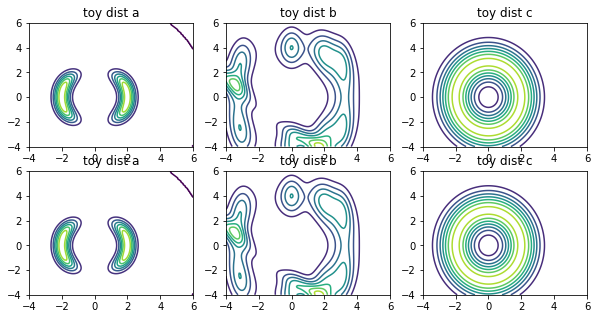

In [ ]:
# target_names = ['pickle2d', 'mixture2d']
import math
from avo.toy_dist import targets
target_names = [t.name for t in targets]

fig, ax = plt.subplots(2, 3, figsize= (10,5))

for i, t_name in enumerate(target_names[:3]):
    targets[i].plot2d_pdf(ax[0][i], bounds=((-4, 6), (-4, 6)))
for i, t_name in enumerate(target_names[3:]):
    targets[i].plot2d_pdf(ax[1][i], bounds=((-4, 6), (-4, 6)))


# HVI AVO

In [ ]:
from avo.models import HVIAVO, HVIELBO
import pytorch_lightning as pl
import torch.nn as nn

In [ ]:
from avo.toy_dist import ToyD

class AnnealedTarget(ToyD):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self.name = 'four-mode mixture annealed'
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E(self, x):
        part1 = torch.sum(torch.distributions.normal.Normal(
            torch.tensor([-2., 0], device=self.device), 0.2).log_prob(x), dim=1) + np.log(0.1)
        part2 = torch.sum(torch.distributions.normal.Normal(
            torch.tensor([2., 0], device=self.device), 0.2).log_prob(x), dim=1) + np.log(0.3)
        part3 = torch.sum(torch.distributions.normal.Normal(
            torch.tensor([0, 2.], device=self.device), 0.2).log_prob(x), dim=1) + np.log(0.4)
        part4 = torch.sum(torch.distributions.normal.Normal(
            torch.tensor([0, -2.], device=self.device), 0.2).log_prob(x), dim=1) + np.log(0.2)
        ret = -torch.logsumexp(torch.stack([part1, part2, part3, part4], dim=0), dim=0)

        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

In [ ]:
models = {}
from avo.models import HVIAVO, HVIELBO
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=10, gpus=0)

depth = 10
alphas = np.linspace(0., 1., depth)
transitions_targets = [AnnealedTarget(i) for i in alphas]

models['2d'] = HVIAVO(2, depth, targets = transitions_targets, 
                        batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()

trainer.fit(models['2d'], models['2d'].data_loader(10000));

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   


tensor([-0.2043, -0.2786])
tensor([-0.4947,  0.5637])
tensor([-0.4391,  0.1290])
tensor([ 0.4190, -0.5669])
tensor([-0.4059, -0.3937])
tensor([-0.1901,  0.4773])
tensor([-0.1233, -0.0719])
tensor([-0.4560, -0.4548])
tensor([ 0.3084, -0.2184])
tensor([0.1622, 0.1951])


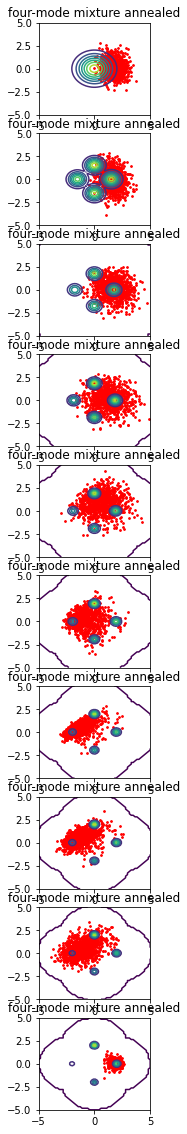

In [ ]:
x = models['2d'].sample(1000).cpu().detach().numpy()
x = torch.tensor(x)

fig, ax = plt.subplots(depth, 1, figsize= (2, 2 * depth))

for i in range(len(models['2d']._transitions)):
    x, log_probability = models['2d']._transitions[i](x)
    z = x.clone()
    z = x.detach().numpy()
    ax[i].scatter(z[:, 0], z[:, 1], s=3, color="red")
    models['2d']._transitions_targets[i].plot2d_pdf(ax[i], bounds=((-5, 5), (-5, 5)), n_points=60)
    print(models['2d']._transitions[i]._reverse_module._linear_sigma.bias.data)

plt.savefig("out1.png", dpi = 320)

In [ ]:
torch.nn.Softplus()(torch.tensor([-4.5]))

tensor([0.0110])

In [ ]:
# trainer.test(models['mixture2d'], models['mixture2d'].data_loader(200));
trainer.test(models['2d'], models['2d'].data_loader(200));

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'energy': tensor(2.2060), 'entropy': tensor(-0.9657), 'loss': tensor(1.2403)}
--------------------------------------------------------------------------------



In [ ]:
trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=10, gpus=0)

depth = 10
alphas = np.linspace(0., 1., depth)
# transitions_targets = [AnnealedTarget(i) for i in alphas]

models['elbo2d'] = HVIELBO(2, depth, AnnealedTarget(1), 
                        batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()
trainer.fit(models['elbo2d'], models['elbo2d'].data_loader(6000));

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   


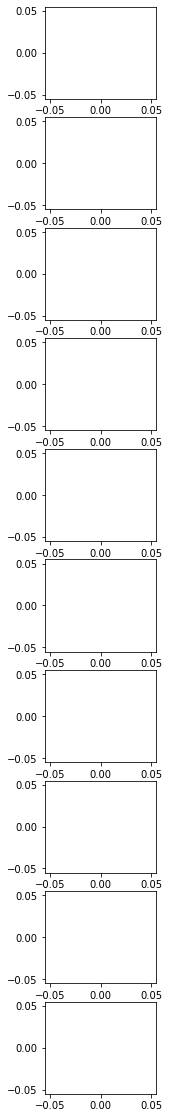

In [ ]:
x = models['elbo2d'].sample(1000).cpu().detach()

fig, ax = plt.subplots(depth, 1, figsize= (2, 2 * depth))

for i in range(depth):
    x, log_probability = models['elbo2d']._transitions[i](x)
    z = x.clone()
    z = x.detach().numpy()
    ax[i].scatter(z[:, 0], z[:, 1], s=3, color="blue")
    # models['2d']._transitions_targets[i].plot2d_pdf(ax[i], bounds=((-5, 5), (-5, 5)), n_points=60)
    # print(models['2d']._transitions[i]._reverse_module._linear_sigma.bias.data)

plt.savefig("elbo transitions.png", dpi = 320)

In [ ]:
%ls

avo/  hviavo_1.png  lightning_logs/  out1.png  requirements.txt  setup.py


In [ ]:
depth = 16
alphas = np.linspace(0., 1., depth)
transitions_targets = [AnnealedTarget(i) for i in alphas]

models['2d'] = HVIAVO(2, depth, targets = transitions_targets, 
                        batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()

trainer.fit(models['2d'], models['2d'].data_loader(10000));


  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 768   


ModuleAttributeError: ignored

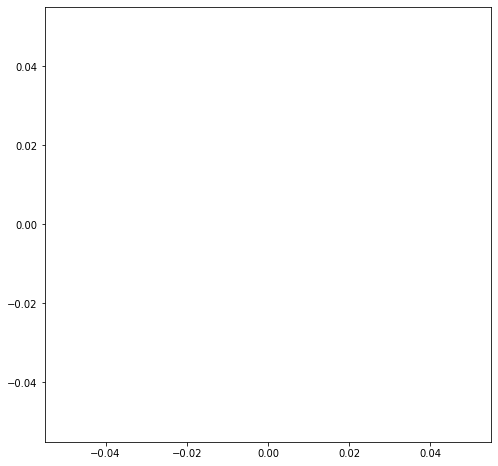

In [ ]:
fig, ax = plt.subplots(figsize= (8, 8))

x = models['2d'].sample(10000).cpu().detach().numpy()
x = torch.tensor(x)
for i in range(len(models['2d']._transitions)):
    x, log_probability = models['2d']._transitions[i](x)
z = x.clone().detach().numpy()
plt.scatter(z[:, 0], z[:, 1], s=3, color="red")

# for i in range(len(models['2d']._transitions)):
#     x, log_probability = models['2d']._transitions[i](x)
#     z = x.clone()
#     z = x.detach().numpy()
#     ax[i].scatter(z[:, 0], z[:, 1], s=3, color="red")
#     models['2d']._transitions_targets[i].plot2d_pdf(ax[i], bounds=((-5, 5), (-5, 5)), n_points=60)
#     print(models['2d']._transitions[i]._reverse_module._linear_sigma.bias.data)
# models['2d']._transitions_targets[-1].plot2d_pdf(ax, bounds=((-5, 5), (-5, 5)), n_points=60)
plt.savefig("out1.png", dpi = 320)

In [96]:
from avo.toy_dist import ToyA, ToyB, ToyC, ToyD, ToyE, ToyF 

class AnnealedA(ToyA):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E(self, x):
        ret = super().E(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

class AnnealedB(ToyB):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E(self, x):
        ret = super().E(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann


class AnnealedC(ToyC):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E(self, x):
        ret = super().E(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

class AnnealedD(ToyD):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E(self, x):
        ret = super().E(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

class AnnealedE(ToyE):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha

    def E0(self, z):
        w1 = torch.sin(math.pi * 0.5 * z[:, 0])
        w2 = 3 * torch.exp(-0.5 * (z[:, 0] - 2)**2)
        # return - 0.5 * ((z[:, 1] - 2) / 0.4)**2 - 0.1 * z[:, 0]**2
        a = -0.5 * ((z[:, 1] - w1) / 0.4)**2
        return - a + 0.1 * z[:, 0]**2

    def E(self, x):
        # ret = super().E(x)
        ret = self.E0(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

class AnnealedF(ToyF):
    def __init__(self, alpha = 0, device='cpu'):
        super().__init__()
        self._initial_target = SimpleNormal(device)
        self.alpha = alpha
    
    def E0(self, z):
        w1 = torch.sin(math.pi * 0.5 * z[:, 0])
        w2 = 3 * torch.exp(-0.5 * (z[:, 0] - 2)**2)
        vec = torch.stack((
            -0.5 * ((z[:, 1] - w1) / 0.35)**2,
            -0.5 * ((z[:, 1] - w1 + w2) / 0.35)**2,
        ))
        return -torch.logsumexp(vec, dim=0) + 0.05 * z[:, 0] ** 2

    def E(self, x):
        # ret = super().E(x)
        ret = self.E0(x)
        ann = (1. - self.alpha) * self._initial_target.E(x) + self.alpha * ret
        return ann

depth = 4
alphas = np.linspace(0., 1., depth)
transitions_targets = [
  [AnnealedA(i) for i in alphas],
  [AnnealedB(i) for i in alphas],
  [AnnealedC(i) for i in alphas]
  ]


# fig, ax = plt.subplots(3, depth, figsize= (12, 18))
# targets
# for j in range(depth):
#   for i in range(3):
#       transitions_targets[i][j].plot2d_pdf(ax[i][j], bounds=((-5, 5), (-5, 5)), n_points=60)

# plt.savefig("transitions_targets_abc.png", dpi = 320)

In [ ]:
depth = 10
alphas = np.linspace(0., 1., depth)
transitions_targets = [AnnealedB(i) for i in alphas]

models['toya_hviavo'] = HVIAVO(2, depth, targets = transitions_targets, 
                        batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()

trainer.fit(models['toya_hviavo'], models['toya_hviavo'].data_loader(6000));


  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   


tensor([ 0.0683, -0.3442])
tensor([0.1129, 0.2404])
tensor([ 0.1985, -0.0568])
tensor([0.1448, 0.4261])
tensor([-0.4517,  0.2658])
tensor([-0.2810,  0.6749])
tensor([0.5211, 0.2167])
tensor([-0.0387, -0.4404])
tensor([-0.3536,  0.1207])
tensor([-0.0650,  0.2546])


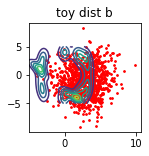

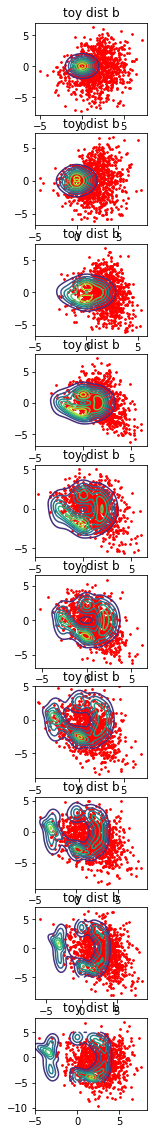

In [ ]:
x = models['toya_hviavo'].sample(1000).cpu()

fig, ax = plt.subplots(1, 1, figsize= (8, 8))
for i in range(len(models['toya_hviavo']._transitions)):
    x, log_probability = models['toya_hviavo']._transitions[i](x)

z = x.clone().detach().numpy()
ax.scatter(z[:, 0], z[:, 1], s=3, color="red")
models['toya_hviavo']._transitions_targets[-1].plot2d_pdf(ax, bounds=((-5, 5), (-5, 5)), n_points=60)
# print(models['2d']._transitions[i]._reverse_module._linear_sigma.bias.data)
plt.savefig("out toy a hvi avo.png", dpi = 320)

fig, ax = plt.subplots(depth, 1, figsize= (2, 2 * depth))

x = models['toya_hviavo'].sample(1000).cpu()
for i in range(len(models['toya_hviavo']._transitions)):
    x, log_probability = models['toya_hviavo']._transitions[i](x)
    z = x.clone()
    z = z.detach().numpy()
    models['toya_hviavo']._transitions_targets[i].plot2d_pdf(ax[i], bounds=((-5, 5), (-5, 5)), n_points=60)

    ax[i].scatter(z[:, 0], z[:, 1], s=3, color="red")
    print(models['toya_hviavo']._transitions[i]._reverse_module._linear_sigma.bias.data)

plt.savefig("out toy a hvi avo all_iter.png", dpi = 320)

In [97]:
depth = 10
alphas = np.linspace(0., 1., depth)
# transitions_targets = [AnnealedB(i) for i in alphas]

transitions_targets = [
  # [AnnealedA(i) for i in alphas],
  # [AnnealedB(i) for i in alphas],
  # [AnnealedC(i) for i in alphas],
  # [AnnealedD(i) for i in alphas],
  [AnnealedE(i) for i in alphas],
  [AnnealedF(i) for i in alphas]
]

mnames = [
          # 'toya_hviavo a', 
          # 'toya_hviavo b', 'toya_hviavo c', 
          # 'toya_hviavo d', 
          'toya_hviavo e', 'toya_hviavo f'
          ]

for k, transitions_target in enumerate(transitions_targets):
    if transitions_target:
        model = HVIAVO(2, depth, targets = transitions_target, 
                                batch_size=64,  lr=1e-3, hidden_dimension=2, optimizer="sgd").cpu()
        trainer.fit(model, model.data_loader(2000));
        models[mnames[k]] = model


  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   



  | Name         | Type       | Params
--------------------------------------------
0 | _transitions | ModuleList | 480   


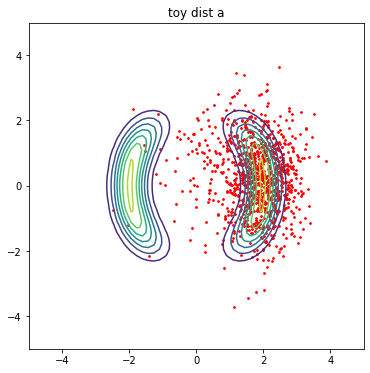

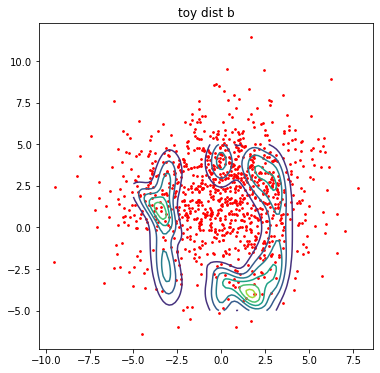

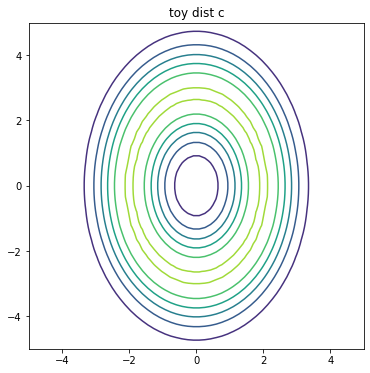

In [ ]:
for k, mname in enumerate(mnames):
    model = models[mname]
    x = model.sample(1000).cpu()
    fig, ax = plt.subplots(1, 1, figsize= (6, 6))
    for i in range(len(model._transitions)):
        x, log_probability = model._transitions[i](x)
    z = x.clone().detach().numpy()
    ax.scatter(z[:, 0], z[:, 1], s=3, color="red")
    model._transitions_targets[-1].plot2d_pdf(ax, bounds=((-5, 5), (-5, 5)), n_points=60)
    # print(models['2d']._transitions[i]._reverse_module._linear_sigma.bias.data)
    
    plt.savefig("./img/{} hvi avo.png".format(mname), dpi = 320)